# CIS6800: Project 3: SOLO and FPN (Instance Segmentation)


### Instructions:
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* You may include any code used in previous projects. You may use ChatGPT, but you need to document how you use it.
* You should expect that a complete training session should last about 6 hours, so you should start part (b) as early as you can!
* To save on compute time, we debugging locally and using colab to train. Or use colab cpu instance for debugging
* We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so. You do not, however, need to submit your trained weights.


The SOLO paper: https://arxiv.org/pdf/1912.04488.pdf


In [ ]:
# download data, if the auto download faild, you can maunally download here:
# https://drive.google.com/drive/folders/17cT1ywZeKJ5l-FinBwpWv-EbvaMJ9mSa?usp=sharing

!gdown --id 1JD3OaHpq_4KCb7ofcPMkknmdEXFHrCcn
!gdown --id 1ssRA7yijGLFmJU-ac-lPyUOq7DYzTAS1
!gdown --id 1Rpz-ZuQxDwvLyzc0FD9GZxAKlyka3VC5
!gdown --id 1ouMFNT1thia8l6P5vcWCY-nweAexLDsB
!pip install pytorch-lightning

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1JD3OaHpq_4KCb7ofcPMkknmdEXFHrCcn 

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.c

## Code Structure
In this assignment, we are only providing the barest templates for your code structure. If you prefer, you can write and debug most of the components in a regular python and only use Jupyter to train. In this case, you might have several files that you import into this notebook, e.g.
* `dataset.py`
* `model.py`
* `train.py`
* `inference.py`

This is shown below. All files should be included in your submission.

In [ ]:
try:
    import dataset
    import model
    import train
    import inference
except ModuleNotFoundError:
    pass

## Overview

Instance segmentation can be thought of as a combination of object detection and semantic segmentation, the former of which you already explored in the previous project. A visulization of this relationship can be seen in fig. 1.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig1.png" width=500/></div>
<center>Figure 1: An overview of instance segmentation.</center>  

In this project, you are tasked with implementing an instance segmentation framework know as SOLO (Segmenting Object by LOcations). In a similar manner to YOLO, SOLO produces mask predictions on a dense grid. This means that, unlike many other segmenation frameworks (e.g. Mask-RCNN), SOLO directly predicts the segmentation mask without proposing bounding box locations. An visual summary of SOLO can be seen in fig. 2 and 3.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig2.png" width=200/></div>
<center>Figure 2: SOLO.</center>  

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig3.png" width=600/></div>
<center>Figure 3: SOLO branches.</center>

These dense predictions are produced at several different scales using a Feature Pyramid Network (FPN). Using the last few layers of the backbone, we pass the higher level features from the deeper layers back up to larger features scales using lateral connections, shown in fig. 4. The integration of the FPN into your network will be the primary focus of this project.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig4.png" width=300/></div>
<center>Figure 4: SOLO branches.</center>

## Part A

### Dataset
#### Dataset Structure
The dataset used in this project contains three classes across 3265 images: vehicles, people, and animals. The dataset contains the following elements:

* A numpy array of images ($3 \times 300 \times 400$).
* A numpy array of masks ($300 \times 400$).
* A list of ground truth labels by image.
* A list of bounding boxes by image.

Note that the mask array is flattened; to determine which masks belong to which image, count the number of labels associated with that image. For example, if the first few images have 3, 2, and 4 labels, masks 0-2 would belong to image 1, masks 3-4 would belong to image 2, etc. The masks are ordered correctly to allow for this.

#### Loading and Batching
You should apply the following transformations to each image:
* Normalize pixel values to $[0,1]$.
* Rescale the image to $800 \times 1066$.
* Normalize each channel with means $[0.485, 0.456, 0.406]$ and standard deviations $[0.229, 0.224, 0.225]$.
* Zero pad the image to $800 \times 1088$.

Since each image will have a different number of objects, you will have to write your own collation function to properly batch the images. An example collate_fn is shown below, along with expected output dimensions.

In [ ]:
# images:         (batch_size, 3, 800, 1088)
# labels:         list with len: batch_size, each (n_obj,)
# masks:          list with len: batch_size, each (n_obj, 800,1088)
# bounding_boxes: list with len: batch_size, each (n_obj, 4)
def collate_fn(batch):
    images, labels, masks, bounding_boxes = list(zip(*batch))
    return torch.stack(images), labels, masks, bounding_boxes

#### Visualization
In order to validate that you are loading the dataset correct, you should plot at least five example images that include the mask, annotations, and bounding boxes. Examples of such images are shown in fig. 5 and 6. Make sure that the color for each class is consistent!

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig5.png" width=500/></div>
<center>Figure 5: Example visualization.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig6.png" width=500/></div>
<center>Figure 6: Example visualization.</center>

### Model
#### Architecture
The model architecture is summarized in fig. 7 and tables 1 and 2.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig7.png" width=500/></div>
<center>Figure 7: SOLO branch structure.</center>
<br>
<center>Table 1: Category branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 3\times3\times(C-1)$, stride $= 1$, pad $= 1$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note $C = 4$ here (number of classes + background). |

<br>
<center>Table 2: Mask branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times(256 + 2)$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Two additional input channels represent the $x$ and $y$ positional encoding. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 1\times1\times(\text{num_grid})^2$, stride $= 1$, pad $= 0$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note that $\text{num_grid}$ is different for each layer of the FPN. |

We will be using a pretrained backbone (which includes an FPN), so you will not have to implement those components. A template for the network with along with default parameters is shown below.

#### Feature Pyramid
The feature pyramid extracted below has strides $[4,8,16,32,64]$ over the original image. To match the SOLO paper, this should be interpolated to have strides $[8,8,16,32,32]$.

#### Target Assignment
Some notes about generating the ground truth targets:
* The FPN levels can be though of as different grid sizes cut through the image.
* You assign each target to a certain FPN level if $\sqrt{wh}$ from the bounding box falls within the `scale_range` associated with that level. Note that these overlap, so you may assign the same target to multiple levels.
* A grid cell should be considered as predicting an object if that grid cell falls into the "centre region" of the object.
 * The centre region of an object is its bounding box scaled by `epsilon`.
 * Each grid cell can predict at most one object, but each object can be predicted by more than one grid cell.

#### Target Visualization
You should produce visualizations such as fig. 8 and 9 to validate your target assignments.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig8.png" width=500/></div>
<center>Figure 8: Target assignment example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig9.png" width=500/></div>
<center>Figure 9: Target assignment example.</center>

In [ ]:
import torchvision
import torch
from functools import partial
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import h5py

In [ ]:
def Resnet50Backbone(checkpoint_file=None, device="cpu", eval=True):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)

    if eval == True:
        model.eval()

    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    resnet50_fpn = model.backbone

    if checkpoint_file:
        checkpoint = torch.load(checkpoint_file)

        resnet50_fpn.load_state_dict(checkpoint['backbone'])

    return resnet50_fpn

In [ ]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        # self.img_data = np.load(path[0], allow_pickle=True)
        with h5py.File(path[0], 'r') as f:
            self.imgs_data = np.array(f['data'])

        with h5py.File(path[1], 'r') as f:
            self.mask_data = np.array(f['data'])
            # self.mask_data = np.load(path[1], allow_pickle=True)
        self.label_data = np.load(path[2], allow_pickle=True)
        self.bbox_data = np.load(path[3], allow_pickle=True)

        ## creatig masks list that is currently flattened
        self.maskList = []
        start = 0

        for label in self.label_data:
            num_masks = label.shape[0]
            self.maskList.append(np.array(self.mask_data[start:start + num_masks]))
            start += num_masks

        self.mask_data = self.maskList

        # TODO: load dataset, make mask list

    # output:
    # transed_img
    # label
    # transed_mask
    # transed_bbox
    def __getitem__(self, index):
        img = self.imgs_data[index]
        mask = self.mask_data[index]
        label = self.label_data[index]
        bbox = self.bbox_data[index].copy()

        ## changing the coordinates bounding box to match with the image rescaled to 800*1088

        original_w, original_h, new_w, new_h = 400, 300, 1066, 800

        bbox[:, 0] = bbox[:, 0] * (new_w / original_w)
        bbox[:, 1] = bbox[:, 1] * (new_h / original_h)
        bbox[:, 2] = bbox[:, 2] * (new_w / original_w)
        bbox[:, 3] = bbox[:, 3] * (new_h / original_h)

        ##doing padding from 1066 to 1088
        bbox[:, [0, 2]] += 11

        transed_img, transed_mask, transed_bbox = self.pre_process_batch(img, mask, bbox)

        # check flag
        assert transed_img.shape == (3, 800, 1088)
        assert transed_bbox.shape[0] == transed_mask.shape[0]
        return transed_img, transed_mask, label, transed_bbox

    def __len__(self):
        return len(self.imgs_data)

    # This function take care of the pre-process of img,mask,bbox
    # in the input mini-batch
    # input:
    # img: 3*300*400
    # mask: 3*300*400
    # bbox: n_box*4
    def pre_process_batch(self, img, mask, bbox):
        # normalize image between 0 and 1
        img = img / 255.0

        ##rescale img to 800*1600
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        img = F.interpolate(img, size=(800, 1066), mode='bilinear', align_corners=False).squeeze(0)

        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        mask = F.interpolate(mask, size=(800, 1066), mode='nearest').squeeze(
            0)  ## dont squeeze a dimension here as the check below is doing that in the assert statement

        # normalize each channel
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        img = torchvision.transforms.functional.normalize(img, mean, std)

        ##zero padding the image to 800*1088
        img = F.pad(img, (11, 11), mode='constant', value=0)  # pad last dim by 11 on each side
        mask = F.pad(mask, (11, 11), mode='constant', value=0)

        # mask = torch.tensor(mask)
        bbox = torch.tensor(bbox)

        # check flag
        assert img.shape == (3, 800, 1088)
        assert mask.shape[1] == 800
        assert mask.shape[-1] == 1088
        assert mask.shape[-2] == 800
        assert bbox.shape[0] == mask.shape[0]  # mask.squeeze(0).shape[0]
        return img, mask, bbox


class BuildDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size, shuffle, num_workers):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers

    # output:
    # img: (bz, 3, 800, 1088)
    # label_list: list, len:bz, each (n_obj,)
    # transed_mask_list: list, len:bz, each (n_obj, 800,1088)
    # transed_bbox_list: list, len:bz, each (n_obj, 4)
    # img: (bz, 3, 300, 400)
    def collect_fn(self, batch):  # should be collate_fn but I wont change it here
        imgs, masks, labels, bboxes = list(zip(*batch))

        max_obj = max([bbox.shape[0] for bbox in bboxes])

        imgs = torch.stack([torch.tensor(img) for img in imgs], dim=0)
        padded_masks, padded_bboxes, padded_labels = [], [], []

        for mask, bbox, label in zip(masks, bboxes, labels):
            pad_mask = torch.zeros(max_obj, 800, 1088)
            pad_mask[:mask.shape[0], :, :] = torch.tensor(mask)
            padded_masks.append(pad_mask)

            pad_bbox = torch.zeros(max_obj, 4)
            pad_bbox[:bbox.shape[0], :] = torch.tensor(bbox)
            padded_bboxes.append(pad_bbox)

            pad_labels = torch.zeros(max_obj)
            pad_labels[:label.shape[0]] = torch.tensor(label)
            padded_labels.append(pad_labels)

        padded_bboxes = torch.stack(padded_bboxes, dim=0)
        padded_masks = torch.stack(padded_masks, dim=0)
        padded_labels = torch.stack(padded_labels, dim=0)

        return imgs, padded_masks, padded_labels, padded_bboxes


    def loader(self):
        return torch.utils.data.DataLoader(self.dataset,
                                           batch_size=self.batch_size,
                                           shuffle=self.shuffle,
                                           num_workers=self.num_workers,
                                           collate_fn=self.collect_fn)


def PlotGT_with_Bounding_Boxes(bbox_list, label_list, mask_list, img):
    num_images = img.shape[0]

    img_np = img.permute(0, 2, 3, 1).cpu().numpy()
    for i in range(num_images):
        fig, ax = plt.subplots(1)
        min_val = np.min(img_np[i])
        max_val = np.max(img_np[i])
        image_for_plotting = (img_np[i] - min_val) / (max_val - min_val)
        ax.imshow(image_for_plotting)
        for j in range(bbox_list[i].shape[0]):
            x1, y1, x2, y2 = bbox_list[i][j]
            width = x2 - x1
            height = y2 - y1
            color_keys = ['r', 'g', 'b']
            category_label = int(label_list[i][j].item())
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2,
                                edgecolor=color_keys[category_label - 1], facecolor='none')
            ax.add_patch(rect)
            mask = mask_list[i][j]
            mask_np = F.interpolate(mask.unsqueeze(0).unsqueeze(0), size=(img.shape[-2], img.shape[-1]),
                                mode='bilinear', align_corners=False).squeeze(0).squeeze(0).cpu().numpy()
            rgb_mask = np.zeros_like(img_np[i])
            rgb_mask[:, :, category_label - 1] = mask_np
            ax.imshow(rgb_mask, alpha=0.5)

        ax.set_title("Ground Truth Image " + str(iter*2+i) + " with Bounding Boxes and Masks")
        os.makedirs("./testfig", exist_ok=True)
        plt.savefig("./testfig/dataset_plot_" + str(iter*2+i) + ".png")
        plt.show()

        if i == 1:
            break

In [ ]:
class SOLOHead(nn.Module):
    def __init__(self,
                 num_classes,
                 in_channels=256,
                 seg_feat_channels=256,
                 stacked_convs=7,
                 strides=[8, 8, 16, 32, 32],
                 scale_ranges=((1, 96), (48, 192), (96, 384), (192, 768), (384, 2048)),
                 epsilon=0.2,
                 num_grids=[40, 36, 24, 16, 12],
                 cate_down_pos=0,
                 with_deform=False,
                 mask_loss_cfg=dict(weight=3),
                 cate_loss_cfg=dict(gamma=2,
                                    alpha=0.25,
                                    weight=1),
                 postprocess_cfg=dict(cate_thresh=0.2,
                                      ins_thresh=0.5,
                                      pre_NMS_num=50,
                                      keep_instance=5,
                                      IoU_thresh=0.5)):
        super(SOLOHead, self).__init__()
        self.num_classes = num_classes
        self.seg_num_grids = num_grids
        self.cate_out_channels = self.num_classes
        self.in_channels = in_channels
        self.seg_feat_channels = seg_feat_channels
        self.stacked_convs = stacked_convs
        self.strides = strides
        self.epsilon = epsilon
        self.cate_down_pos = cate_down_pos
        self.scale_ranges = scale_ranges
        self.with_deform = with_deform

        self.mask_loss_cfg = mask_loss_cfg
        self.cate_loss_cfg = cate_loss_cfg
        self.postprocess_cfg = postprocess_cfg
        # initialize the layers for cate and mask branch, and initialize the weights
        self._init_layers()
        self._init_weights()

        self.lateral_convs = nn.ModuleList(
            [nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0) for _ in range(len(num_grids))])

        # check flag
        assert len(self.ins_head) == self.stacked_convs
        assert len(self.cate_head) == self.stacked_convs
        assert len(self.ins_out_list) == len(self.strides)
        pass


    # This function builds network layer for cate and ins branch
    # it builds 4 self.var
    # self.cate_head is nn.ModuleList 7 inter-layers of conv2d
    # self.ins_head is nn.ModuleList 7 inter-layers of conv2d
    # self.cate_out is 1 out-layer of conv2d
    # self.ins_out_list is nn.ModuleList len(self.seg_num_grids) out-layers of conv2d, one for each fpn_feat
    def _init_layers(self):
        # define groupnorm
        num_groups = 32
        # initialize the two branch head modulelist
        self.cate_head = nn.ModuleList([

            nn.Sequential(
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.GroupNorm(num_groups, 256),  # normalizes across all the channels
                nn.ReLU()

            ),
            nn.Sequential(
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.GroupNorm(num_groups, 256),  # normalizes across all the channels
                nn.ReLU()

            ),
            nn.Sequential(
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.GroupNorm(num_groups, 256),  # normalizes across all the channels
                nn.ReLU()

            ),
            nn.Sequential(
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.GroupNorm(num_groups, 256),  # normalizes across all the channels
                nn.ReLU()

            ),
            nn.Sequential(
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.GroupNorm(num_groups, 256),  # normalizes across all the channels
                nn.ReLU()

            ),
            nn.Sequential(
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.GroupNorm(num_groups, 256),  # normalizes across all the channels
                nn.ReLU()

            ),
            nn.Sequential(
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.GroupNorm(num_groups, 256),  # normalizes across all the channels
                nn.ReLU()

            )
        ])

        self.cate_out = nn.Sequential(
            nn.Conv2d(256, 4, kernel_size=3, stride=1, padding=1, bias=True),
            nn.Sigmoid()
        )

        # instance mask head
        self.ins_head = nn.ModuleList([

            nn.Sequential(nn.Conv2d(258, 256, kernel_size=3, stride=1, padding=1, bias=False),
                          nn.GroupNorm(num_groups, 256),
                          nn.ReLU()
                          ),
            nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                          nn.GroupNorm(num_groups, 256),
                          nn.ReLU()
                          ),
            nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                          nn.GroupNorm(num_groups, 256),
                          nn.ReLU()
                          ),
            nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                          nn.GroupNorm(num_groups, 256),
                          nn.ReLU()
                          ),
            nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                          nn.GroupNorm(num_groups, 256),
                          nn.ReLU()
                          ),
            nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                          nn.GroupNorm(num_groups, 256),
                          nn.ReLU()
                          ),
            nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                          nn.GroupNorm(num_groups, 256),
                          nn.ReLU()
                          )
        ])

        # initialize the output layer
        self.ins_out_list = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(256, num_grid ** 2, kernel_size=1, stride=1, padding=0, bias=True),
                nn.Sigmoid()
            )
            for num_grid in self.seg_num_grids

        ])


    # This function initialize weights for head network
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            if isinstance(m, nn.GroupNorm):
                nn.init.constant_(m.weight, 1)  # check this
                nn.init.constant_(m.bias, 0)


    # Forward function should forward every levels in the FPN.
    # this is done by map function or for loop
    # Input:
    # fpn_feat_list: backout_list of resnet50-fpn
    # Output:
    # if eval = False
    # cate_pred_list: list, len(fpn_level), each (bz,C-1,S,S)
    # ins_pred_list: list, len(fpn_level), each (bz, S^2, 2H_feat, 2W_feat)
    # if eval==True
    # cate_pred_list: list, len(fpn_level), each (bz,S,S,C-1) / after point_NMS
    # ins_pred_list: list, len(fpn_level), each (bz, S^2, Ori_H, Ori_W) / after upsampling
    def forward(self,
                fpn_feat_list,
                device,
                eval=False):
        new_fpn_list = self.NewFPN(fpn_feat_list)  # stride[8,8,16,32,32]
        assert new_fpn_list[0].shape[1:] == (256, 100, 136)
        quart_shape = [new_fpn_list[0].shape[-2] * 2, new_fpn_list[0].shape[-1] * 2]  # stride: 4
        cate_pred_list, ins_pred_list = self.MultiApply(self.forward_single_level, new_fpn_list,
                                                        list(range(len(self.seg_num_grids))), device=device, eval=eval,
                                                        upsample_shape=quart_shape)
        assert len(new_fpn_list) == len(self.seg_num_grids)

        #print("Cate Pred List Shape = " + str(cate_pred_list[1].shape))
        if eval:
            assert cate_pred_list[1].shape[3] == self.cate_out_channels
        else:
            assert cate_pred_list[1].shape[1] == self.cate_out_channels
        assert ins_pred_list[1].shape[1] == self.seg_num_grids[1] ** 2
        assert cate_pred_list[1].shape[2] == self.seg_num_grids[1]
        return cate_pred_list, ins_pred_list


    # This function upsample/downsample the fpn level for the network
    # In paper author change the original fpn level resolution
    # Input:
    # fpn_feat_list, list, len(FPN), stride[4,8,16,32,64]
    # Output:
    # new_fpn_list, list, len(FPN), stride[8,8,16,32,32]
    def NewFPN(self, fpn_feat_list):
        new_fpn_list = [None] * len(fpn_feat_list)

        for i in range(len(fpn_feat_list)):
            fpn_feat = self.lateral_convs[i](fpn_feat_list[i])

            new_fpn_list[i] = fpn_feat

        for i in range(len(fpn_feat_list) - 1, 0, -1):
            new_fpn_list[i - 1] = new_fpn_list[i - 1] + F.interpolate(new_fpn_list[i], size=(
            new_fpn_list[i - 1].shape[-2], new_fpn_list[i - 1].shape[-1]), mode='bilinear', align_corners=False)

        new_fpn_list[0] = torch.nn.functional.interpolate(new_fpn_list[0], scale_factor=0.5)
        new_fpn_list[-1] = torch.nn.functional.interpolate(new_fpn_list[-1], size=(25, 34))

        return new_fpn_list


    # This function forward a single level of fpn_featmap through the network
    # Input:
    # fpn_feat: (bz, fpn_channels(256), H_feat, W_feat)
    # idx: indicate the fpn level idx, num_grids idx, the ins_out_layer idx
    # Output:
    # if eval==False
    # cate_pred: (bz,C-1,S,S)
    # ins_pred: (bz, S^2, 2H_feat, 2W_feat)
    # if eval==True
    # cate_pred: (bz,S,S,C-1) / after point_NMS
    # ins_pred: (bz, S^2, Ori_H/4, Ori_W/4) / after upsampling
    def forward_single_level(self, fpn_feat, idx, device="cpu", eval=False, upsample_shape=None, prev_feat=None):
        # upsample_shape is used in eval mode

        fpn_feat = fpn_feat.to(device)

        fpn_feat_coords = self.add_xy_coords(fpn_feat, device)
        cate_pred = fpn_feat
        ins_pred = fpn_feat_coords
        num_grid = self.seg_num_grids[idx]

        cate_pred = F.interpolate(cate_pred, size=(num_grid, num_grid), mode='bilinear', align_corners=False)

        for cat_layer in self.cate_head:
            cate_pred = cat_layer(cate_pred)

        for ins_layer in self.ins_head:
            ins_pred = ins_layer(ins_pred)

        cate_pred = self.cate_out(cate_pred)
        ins_pred = self.ins_out_list[idx](ins_pred)

        # in inference time, upsample the pred to (ori image size/4)
        if eval == True:
            if upsample_shape is not None:
                ins_pred = F.interpolate(ins_pred, size=upsample_shape, mode='bilinear', align_corners=False)
                ## after upsampling the dimensions should be (bz, S^2, Ori_H/4, Ori_W/4)

            cate_pred = self.points_nms(cate_pred).permute(0, 2, 3, 1)

        # check flag
        if eval == False:
            ins_pred = F.interpolate(ins_pred, size=(2 * fpn_feat.shape[-2], 2 * fpn_feat.shape[-1]), mode='bilinear',
                                     align_corners=False)
            assert cate_pred.shape[1:] == (4, num_grid, num_grid)
            assert ins_pred.shape[1:] == (num_grid ** 2, fpn_feat.shape[2] * 2, fpn_feat.shape[3] * 2)
        else:
            pass
        del fpn_feat, fpn_feat_coords
        if device == 'cuda':
            torch.cuda.empty_cache()
        return cate_pred, ins_pred


    def add_xy_coords(self, fpn_feat, device):
        batch_size, _, H, W = fpn_feat.shape

        x_coords = torch.linspace(-1, 1, steps=W).view(1, 1, 1, W).expand(batch_size, 1, H, W).to(device)
        y_coords = torch.linspace(-1, 1, steps=H).view(1, 1, H, 1).expand(batch_size, 1, H, W).to(device)

        fpn_feat_with_coords = torch.cat([fpn_feat, x_coords, y_coords], dim=1)
        del x_coords, y_coords
        if device == 'cuda':
            torch.cuda.empty_cache()
        return fpn_feat_with_coords


    # Credit to SOLO Author's code
    # This function do a NMS on the heat map(cate_pred), grid-level
    # Input:
    # heat: (bz,C-1, S, S)
    # Output:
    # (bz,C-1, S, S)
    def points_nms(self, heat, kernel=2):
        # kernel must be 2
        hmax = nn.functional.max_pool2d(
            heat, (kernel, kernel), stride=1, padding=1)
        keep = (hmax[:, :, :-1, :-1] == heat).float()
        return heat * keep


    # This function compute loss for a batch of images
    # input:
    # cate_pred_list: list, len(fpn_level), each (bz,C-1,S,S)
    # ins_pred_list: list, len(fpn_level), each (bz, S^2, 2H_feat, 2W_feat)
    # ins_gts_list: list, len(fpn_level), (bz, S^2, 2H_f, 2W_f)
    # ins_ind_gts_list: list, len(fpn_level), (bz, S^2)
    # cate_gts_list: list, len(fpn_level), (bz, S, S), {1,2,3}
    # output:
    # cate_loss, mask_loss, total_loss
    def loss(self,
             cate_pred_list,
             ins_pred_list,
             ins_gts_list,
             ins_ind_gts_list,
             cate_gts_list,
             all_levels_one_batch,
             device):

        batch_size = ins_ind_gts_list[0].shape[0]
        C = self.cate_out_channels

        cate_loss_lambda = 10
        mask_loss_lambda = 1

        cate_preds = torch.zeros((batch_size * all_levels_one_batch, C)).to(device)
        cate_gts = torch.zeros(batch_size * all_levels_one_batch).int().to(device)

        prev_threshold = 0
        divide_tensor = torch.zeros_like(cate_gts).to(device)
        for batch_idx in range(batch_size):
            for fpn_idx in range(len(self.seg_num_grids)):
                new_threshold = prev_threshold + self.seg_num_grids[fpn_idx] ** 2
                cate_gts[prev_threshold:new_threshold] = cate_gts_list[fpn_idx][batch_idx].int().flatten().to(device)
                cate_preds[prev_threshold:new_threshold] = cate_pred_list[fpn_idx][batch_idx].flatten(start_dim=1).T.to(device)
                divide_tensor[prev_threshold:new_threshold] = C * (self.seg_num_grids[fpn_idx] ** 2)
                prev_threshold = new_threshold

        focal_loss = self.FocalLoss(cate_preds, cate_gts, device) / batch_size
        cate_loss = (focal_loss / divide_tensor).sum()

        mask_loss = torch.tensor(0.0).to(device)
        num_mask_loss = 0
        for fpn_idx in range(len(self.seg_num_grids)):
            mask_indices = ins_ind_gts_list[fpn_idx].flatten()
            ins_pred = ins_pred_list[fpn_idx].flatten(end_dim=1).to(device)
            ins_gt = ins_gts_list[fpn_idx].flatten(end_dim=1).to(device)
            ins_pred = ins_pred[mask_indices == 1]
            ins_gt = ins_gt[mask_indices == 1]
            if ins_gt.shape[0] > 0:
                mask_loss += self.DiceLoss(ins_pred, ins_gt).mean()
                num_mask_loss += 1

        if num_mask_loss > 0:
            mask_loss /= num_mask_loss

        total_loss = cate_loss_lambda * cate_loss + mask_loss_lambda * mask_loss

        del cate_gts, cate_preds, focal_loss, divide_tensor
        if device == 'cuda':
            torch.cuda.empty_cache()

        return cate_loss, mask_loss, total_loss


    # This function compute the DiceLoss
    # Input:
    # mask_pred: (2H_feat, 2W_feat)
    # mask_gt: (2H_feat, 2W_feat)
    # Output: dice_loss, scalar
    def DiceLoss(self, mask_pred, mask_gt):
        epsilon = 1e-8
        pq_product = mask_pred * mask_gt
        p_squared = mask_pred * mask_pred
        q_squared = mask_gt * mask_gt
        num = 2 * pq_product.sum(dim=(-2, -1))
        denom = p_squared.sum(dim=(-2, -1)) + q_squared.sum(dim=(-2, -1)) + epsilon
        dice_loss = 1 - num / denom
        del pq_product, p_squared, q_squared, num, denom
        return dice_loss


    # This function compute the cate loss
    # Input:
    # cate_preds: (num_entry, C-1)
    # cate_gts: (num_entry,)
    # Output: focal_loss, scalar
    def FocalLoss(self, cate_preds, cate_gts, device):
        epsilon = 1e-8

        alpha = 0.9
        gamma = self.cate_loss_cfg['gamma']

        alpha_vector = alpha * torch.ones_like(cate_gts)
        alpha_vector[cate_gts == 0] = 0.1
        alpha_vector[cate_gts == 1] = 10.0
        alpha_vector[cate_gts == 2] = 10.0

        batch_indices = torch.arange(cate_preds.shape[0])

        focal_loss = -alpha_vector * (1 - cate_preds[batch_indices, cate_gts]) ** gamma * torch.log(
            cate_preds[batch_indices, cate_gts] + epsilon)

        del batch_indices
        if device == 'cuda':
            torch.cuda.empty_cache()

        return focal_loss


    def MultiApply(self, func, *args, **kwargs):
        pfunc = partial(func, **kwargs) if kwargs else func
        map_results = map(pfunc, *args)

        return tuple(map(list, zip(*map_results)))


    # This function build the ground truth tensor for each batch in the training
    # Input:
    # ins_pred_list: list, len(fpn_level), each (bz, S^2, 2H_feat, 2W_feat)
    # / ins_pred_list is only used to record feature map
    # bbox_list: list, len(batch_size), each (n_object, 4) (x1y1x2y2 system)
    # label_list: list, len(batch_size), each (n_object, )
    # mask_list: list, len(batch_size), each (n_object, 800, 1088)
    # Output:
    # ins_gts_list: list, len(fpn), (bz, S^2, 2H_f, 2W_f)
    # ins_ind_gts_list: list, len(fpn), (bz, S^2)
    # cate_gts_list: list, len(fpn), (bz, S, S), {1,2,3}
    def target(self,
               ins_pred_list,
               bbox_list,
               label_list,
               mask_list,
               ins_gts_list,
               device,
               eval=False):

        featmap_sizes = [(ins_pred.shape[-2] // 2, ins_pred.shape[-1] // 2) for ins_pred in ins_pred_list]

        ins_gts_list, ins_ind_gts_list, cate_gts_list = self.target_single_img(bbox_list, label_list, mask_list,
                                                                            ins_gts_list, device, featmap_sizes, eval)

        # check flag
        assert ins_gts_list[1][0].shape == (self.seg_num_grids[1] ** 2, 200, 272)
        assert ins_ind_gts_list[1][0].shape == (self.seg_num_grids[1] ** 2,)
        assert cate_gts_list[1][0].shape == (self.seg_num_grids[1], self.seg_num_grids[1])

        return ins_gts_list, ins_ind_gts_list, cate_gts_list


    # -----------------------------------
    ## process single image in one batch
    # -----------------------------------
    # input:
    # gt_bboxes_raw: bz, n_obj, 4 (x1y1x2y2 system)
    # gt_labels_raw: bz, n_obj,
    # gt_masks_raw: bz, n_obj, H_ori, W_ori
    # featmap_sizes: list of shapes of featmap
    # output:
    # ins_label_list: list, len: len(FPN), (bz, S^2, 2H_feat, 2W_feat)
    # cate_label_list: list, len: len(FPN), (bz, S, S)
    # ins_ind_label_list: list, len: len(FPN), (bz, S^2)
    def target_single_img(self,
                          gt_bboxes_raw,
                          gt_labels_raw,
                          gt_masks_raw,
                          ins_label_list,
                          device,
                          featmap_sizes=None,
                          eval=False):
        batch_size = len(gt_bboxes_raw)
        n_obj = gt_bboxes_raw[0].shape[0]
        H_ori, W_ori = gt_masks_raw[0].shape[1], gt_masks_raw[0].shape[2]

        ins_ind_label_list = []
        cate_label_list = []

        for fpn_idx in range(len(featmap_sizes)):
            H_featmap, W_featmap = featmap_sizes[fpn_idx]
            S = self.seg_num_grids[fpn_idx]

            grid_x, grid_y = torch.meshgrid(torch.arange(S), torch.arange(S), indexing='ij')

            cate_label = torch.zeros((batch_size, S, S), dtype=torch.long).to(device)

            ins_label_list[fpn_idx].zero_()

            ins_ind_label = torch.zeros((batch_size, S * S), dtype=torch.long).to(device)

            scale_x = W_featmap / W_ori
            scale_y = H_featmap / H_ori
            gt_bboxes_scaled = gt_bboxes_raw * torch.tensor([scale_x, scale_y, scale_x, scale_y])

            for batch_idx in range(batch_size):
                for obj_idx in range(n_obj):
                    bbox_sqrt_area = np.sqrt((gt_bboxes_raw[batch_idx, obj_idx, 2] - gt_bboxes_raw[batch_idx, obj_idx, 0]) * (
                                gt_bboxes_raw[batch_idx, obj_idx, 3] - gt_bboxes_raw[batch_idx, obj_idx, 1]))
                    if bbox_sqrt_area >= self.scale_ranges[fpn_idx][0] and bbox_sqrt_area <= self.scale_ranges[fpn_idx][1]:
                        bbox = gt_bboxes_scaled[batch_idx, obj_idx]
                        label = gt_labels_raw[batch_idx, obj_idx]
                        mask = gt_masks_raw[batch_idx, obj_idx]

                        mask_indices = torch.nonzero(mask)
                        if len(mask_indices) > 0:
                            center_of_mass = mask_indices.float().mean(dim=0)
                            center_y_raw, center_x_raw = center_of_mass[0].item(), center_of_mass[1].item()
                        else:
                            center_x_raw = (bbox[0] + bbox[2]) / 2
                            center_y_raw = (bbox[1] + bbox[3]) / 2

                        center_x = center_x_raw * W_featmap / W_ori
                        center_y = center_y_raw * H_featmap / H_ori

                        bbox_width = (bbox[2] - bbox[0]) * 0.2
                        bbox_height = (bbox[3] - bbox[1]) * 0.2

                        new_bbox_x1 = max(center_x - bbox_width / 2, 0)
                        new_bbox_x2 = min(center_x + bbox_width / 2, W_featmap)
                        new_bbox_y1 = max(center_y - bbox_height / 2, 0)
                        new_bbox_y2 = min(center_y + bbox_height / 2, H_featmap)

                        grid_x1 = int(new_bbox_x1 * S / W_featmap)
                        grid_x2 = int(new_bbox_x2 * S / W_featmap)
                        grid_y1 = int(new_bbox_y1 * S / H_featmap)
                        grid_y2 = int(new_bbox_y2 * S / H_featmap)

                        cate_label[batch_idx, grid_y1:grid_y2 + 1, grid_x1:grid_x2 + 1] = int(label.item())

                        grid_mask = (grid_x >= grid_x1) & (grid_x <= grid_x2) & (grid_y >= grid_y1) & (grid_y <= grid_y2)
                        grid_indices = torch.nonzero(grid_mask.reshape(-1)).squeeze()

                        if eval:
                            resized_mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0), size=(200, 272),
                                                         mode='bilinear', align_corners=False).squeeze().to(device)
                        else:
                            resized_mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0), size=(2 * H_featmap,
                                            2 * W_featmap), mode='bilinear', align_corners=False).squeeze().to(device)

                        ins_label_list[fpn_idx][batch_idx, grid_indices] = resized_mask
                        ins_ind_label[batch_idx, grid_indices] = 1

            cate_label_list.append(cate_label)
            ins_ind_label_list.append(ins_ind_label)

        # check flag
        assert ins_label_list[1].shape == (batch_size, 1296, 200, 272)
        assert ins_ind_label_list[1].shape == (batch_size, 1296)
        assert cate_label_list[1].shape == (batch_size, 36, 36)

        return ins_label_list, ins_ind_label_list, cate_label_list


    # This function receive pred list from forward and post-process
    # Input:
    # ins_pred_list: list, len(fpn), (bz,S^2,Ori_H/4, Ori_W/4)
    # cate_pred_list: list, len(fpn), (bz,S,S,C-1)
    # ori_size: [ori_H, ori_W]
    # Output:
    # NMS_sorted_scores_list, list, len(bz), (keep_instance,)
    # NMS_sorted_cate_label_list, list, len(bz), (keep_instance,)
    # NMS_sorted_ins_list, list, len(bz), (keep_instance, ori_H, ori_W)
    def PostProcess(self,
                    ins_pred_list,
                    cate_pred_list,
                    ori_size,
                    device):

        all_levels_one_batch = 0
        for S in self.seg_num_grids:
            all_levels_one_batch += S * S

        NMS_sorted_scores_list = []
        NMS_sorted_cate_label_list = []
        NMS_sorted_ins_list = []

        batch_size = ins_pred_list[0].shape[0]
        fpn_len = len(ins_pred_list)
        for batch_idx in range(batch_size):
            ins_pred_img = torch.zeros((all_levels_one_batch, int(ori_size[0]/4), int(ori_size[1]/4))).to(device)
            cate_pred_img = torch.zeros((all_levels_one_batch, self.cate_out_channels)).to(device)
            start_index = 0
            for fpn_idx in range(fpn_len):
                end_index = start_index + self.seg_num_grids[fpn_idx] ** 2
                ins_pred_img[start_index:end_index] = ins_pred_list[fpn_idx][batch_idx]
                cate_pred_img[start_index:end_index] = torch.flatten(cate_pred_list[fpn_idx][batch_idx], end_dim=1)
                start_index = end_index
            NMS_sorted_scores, NMS_sorted_cate_label, NMS_sorted_ins = self.PostProcessImg(ins_pred_img, cate_pred_img, ori_size, device)
            NMS_sorted_scores_list.append(NMS_sorted_scores)
            NMS_sorted_cate_label_list.append(NMS_sorted_cate_label)
            NMS_sorted_ins_list.append(NMS_sorted_ins)

        return NMS_sorted_scores_list, NMS_sorted_cate_label_list, NMS_sorted_ins_list


    # This function Postprocess on single img
    # Input:
    # ins_pred_img: (all_level_S^2, ori_H/4, ori_W/4)
    # cate_pred_img: (all_level_S^2, C-1)
    # Output:
    # sorted_scores_top_k: (keep_instance,)
    # sorted_cate_top_k: (keep_instance,)
    # sorted_ins_top_k: (keep_instance, ori_H, ori_W)
    def PostProcessImg(self,
                       ins_pred_img,
                       cate_pred_img,
                       ori_size,
                       device):
        k = self.postprocess_cfg['keep_instance']
        mask_thresh = 0.1

        ones_mask = torch.zeros_like(ins_pred_img).to(device)
        ones_mask[ins_pred_img >= mask_thresh] = 1

        max_cate_prob, max_cate_class = torch.max(cate_pred_img, dim=-1)

        scores = (torch.sum(ins_pred_img * ones_mask, dim=(-2, -1)) / torch.sum(ones_mask, dim=(-2, -1))) * max_cate_prob

        sorted_scores, indices = torch.sort(scores, descending=True)
        sorted_ins = ins_pred_img[indices]
        sorted_cate_class = max_cate_class[indices]

        new_scores = self.MatrixNMS(sorted_ins, sorted_scores, device)

        sorted_new_scores, indices = torch.sort(new_scores, descending=True)

        sorted_ins = sorted_ins[indices]
        sorted_cate_class = sorted_cate_class[indices]

        sorted_scores_top_k = sorted_new_scores[:k]
        sorted_cate_top_k = sorted_cate_class[:k]
        sorted_ins_top_k = sorted_ins[:k, :, :]

        sorted_ins_top_k = torch.nn.functional.interpolate(sorted_ins_top_k.unsqueeze(0), size=ori_size).squeeze(0)

        return sorted_scores_top_k, sorted_cate_top_k, sorted_ins_top_k


    # This function perform matrix NMS
    # Input:
    # sorted_ins: (n_act, ori_H/4, ori_W/4)
    # sorted_scores: (n_act,)
    # Output:
    # decay_scores: (n_act,)
    def MatrixNMS(self, sorted_ins, sorted_scores, device, method='linear', gauss_sigma=0.5):
        n = len(sorted_scores)
        sorted_masks = sorted_ins.reshape(n, -1).to(device)
        intersection = torch.mm(sorted_masks, sorted_masks.T)
        areas = sorted_masks.sum(dim=1).expand(n, n).to(device)
        union = areas + areas.T - intersection
        ious = (intersection / union).triu(diagonal=1)

        ious_cmax = ious.max(0)[0].expand(n, n).T
        if method == 'gauss':
            decay = (torch.exp(-(ious ** 2 - ious_cmax ** 2) / gauss_sigma)).to(device)
        else:
            decay = ((1 - ious) / (1 - ious_cmax)).to(device)
        decay = decay.min(dim=0)[0]
        return sorted_scores * decay


    # -----------------------------------
    ## The following code is for visualization
    # -----------------------------------


    # this function visualize the ground truth tensor
    # Input:
    # ins_gts_list: list, len(bz), list, len(fpn), (S^2, 2H_f, 2W_f)
    # ins_ind_gts_list: list, len(bz), list, len(fpn), (S^2,)
    # cate_gts_list: list, len(bz), list, len(fpn), (S, S), {1,2,3}
    # color_list: list, len(C-1)
    # img: (bz,3,Ori_H, Ori_W)
    ## self.strides: [8,8,16,32,32]
    def PlotGT(self,
               ins_gts_list,
               ins_ind_gts_list,
               cate_gts_list,
               img):
        num_images = img.shape[0]

        img_np = img.permute(0, 2, 3, 1).cpu().numpy()
        for i in range(num_images):
            for feat_map in range(len(ins_gts_list[i])):
                fig, ax = plt.subplots(1)
                min_val = np.min(img_np[i])
                max_val = np.max(img_np[i])
                image_for_plotting = (img_np[i] - min_val) / (max_val - min_val)
                ax.imshow(image_for_plotting)
                masks_already_plotted = []
                s = cate_gts_list[i][feat_map].shape[0]
                for grid_idx in range(s * s):
                    if ins_ind_gts_list[i][feat_map][grid_idx] == 1:
                        already_plotted = False
                        for prev_mask in masks_already_plotted:
                            if torch.equal(ins_gts_list[i][feat_map][grid_idx], prev_mask):
                                already_plotted = True
                        if not already_plotted:
                            mask = ins_gts_list[i][feat_map][grid_idx]
                            category_label = cate_gts_list[i][feat_map][grid_idx % s, grid_idx // s].item()
                            mask_np = F.interpolate(mask.unsqueeze(0).unsqueeze(0), size=(img.shape[-2], img.shape[-1]), mode='bilinear',
                                                    align_corners=False).squeeze(0).squeeze(0).cpu().numpy()
                            rgb_mask = np.zeros_like(img_np[i])
                            rgb_mask[:, :, category_label - 1] = mask_np
                            ax.imshow(rgb_mask, alpha=0.5)
                            masks_already_plotted.append(mask)

                ax.set_title("FPN Recovery Plot for Image " + str(iter*2+i) + " at FPN Level " + str(feat_map))
                os.makedirs("./testfig", exist_ok=True)
                plt.savefig("./testfig/fpn_recovery_plot_" + str(iter*2+i) + "_fpn_level_" + str(feat_map) + ".png")
                plt.show()

            if i == 1:
                break


    # This function plot the inference segmentation in img
    # Input:
    # NMS_sorted_scores_list, list, len(bz), (keep_instance,)
    # NMS_sorted_cate_label_list, list, len(bz), (keep_instance,)
    # NMS_sorted_ins_list, list, len(bz), (keep_instance, ori_H, ori_W)
    # color_list: ["jet", "ocean", "Spectral"]
    # img: (bz, 3, ori_H, ori_W)
    def PlotInfer(self,
                  NMS_sorted_scores_list,
                  NMS_sorted_cate_label_list,
                  NMS_sorted_ins_list,
                  img,
                  iter):
        score_plotting_threshold = 0.4
        num_images = img.shape[0]
        keep_instance = NMS_sorted_ins_list[0].shape[0]

        img_np = img.permute(0, 2, 3, 1).cpu().numpy()
        for i in range(num_images):
            fig, ax = plt.subplots(1)
            min_val = np.min(img_np[i])
            max_val = np.max(img_np[i])
            image_for_plotting = (img_np[i] - min_val) / (max_val - min_val)
            ax.imshow(image_for_plotting)
            rgb_mask = np.zeros_like(img_np[i])
            for j in range(1, keep_instance):
                if NMS_sorted_scores_list[i][j] >= score_plotting_threshold:
                    category_label = NMS_sorted_cate_label_list[i][j]
                    rgb_mask[:, :, category_label - 1] += NMS_sorted_ins_list[i][j].detach().cpu().numpy()
            ax.imshow(rgb_mask, alpha=0.5)

            ax.set_title("SOLO Output Plot for Image " + str(iter * num_images + i))
            os.makedirs("./testfig", exist_ok=True)
            plt.savefig("./testfig/solo_output_plot_" + str(iter * num_images + i) + ".png")
            plt.show()

### Part A Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. Should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.

We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so.

## Part B
### Loss
The loss function consists of two parts: category loss and mask loss:
$$L = \lambda_\text{cate} L_\text{cate} + \lambda_\text{mask} L_\text{mask} $$

The category loss is defined as (where $\text{FL}$ is the focal loss)

$$L_\text{cate} = \frac{1}{S^2 C} \sum_{S,S,C} \text{FL}(p_t)$$

$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^\gamma \log{(p_t)}$$

$$(\alpha_t, p_t) = \left\{\begin{array}{lr} (\alpha, \hat{p}) & \text{if }y=1 \\ (1 - \alpha, 1 - \hat{p}) & \text{otherwise}\end{array}\right.$$

while the mask loss is defined as (where $d_\text{mask}$ is the dice loss)

$$L_\text{mask} = \frac{1}{N_\text{positive}} \sum_k \mathbb{1}_{\{p_{i, j} > 0\}} d_\text{mask}(m_k, \hat{m}_k)$$

$$d_\text{mask}(p, q) = 1 - D(p, q)$$

$$D(p, q) = \frac{2 \sum_{x,y}(p_{x,y} \cdot q_{x,y})}{\sum_{x,y}p_{x,y}^2 + \sum_{x,y}q_{x,y}^2}$$

### Post Processing
Post processing consists of three steps: points NMS, concatenation and sorting, and matrix NMS. A summary of each of these steps is provided below. In addition, your final mask prediction should be a binary mask based on the mask thresholding parameter. Some examples of results post-inference are shown in figs. 11-14.


<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig11.png" width=300/></div>
<center>Figure 11: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig12.png" width=300/></div>
<center>Figure 12: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig13.png" width=300/></div>
<center>Figure 13: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig14.png" width=300/></div>
<center>Figure 14: SOLO instance segmentation example.</center>

#### Points NMS
Non-max suppression for the category predictions, applied to each channel sperately. A maxpooling with a kernel size of 2, sample code is included below.

#### Concatenation and Sorting
Here, we merge the predictions across all the FPN levels into a single list of predictions, sorted by their predicted score. This involves rescaling the predicted masks appropriately.

#### Matrix NMS
Inspired by Soft-NMS, MatrixNMS suppresses mask predictions with a lower score based on their similarity to predictions with a higher score in a completely vectorized manner. Sample code is include below.

In [ ]:
# Credit to SOLO Author's code
# This function does NMS on the heat map (category_prediction), grid-level
# Input:
#     heat: (batch_size, C-1, S, S)
# Output:
#     (batch_size, C-1, S, S)
def points_nms(heat, kernel=2):
    # kernel must be 2
    hmax = F.max_pool2d(
        heat, (kernel, kernel), stride=1, padding=1)
    keep = (hmax[:, :, :-1, :-1] == heat).float()
    return heat * keep

# This function performs Matrix NMS
# Input:
#     sorted_masks: (n_active, image_h/4, image_w/4)
#     sorted_scores: (n_active,)
# Output:
#     decay_scores: (n_active,)
def MatrixNMS(sorted_masks, sorted_scores, method='gauss', gauss_sigma=0.5):
    n = len(sorted_scores)
    sorted_masks = sorted_masks.reshape(n, -1)
    intersection = torch.mm(sorted_masks, sorted_masks.T)
    areas = sorted_masks.sum(dim=1).expand(n, n)
    union = areas + areas.T - intersection
    ious = (intersection / union).triu(diagonal=1)

    ious_cmax = ious.max(0)[0].expand(n, n).T
    if method == 'gauss':
        decay = torch.exp(-(ious ** 2 - ious_cmax ** 2) / gauss_sigma)
    else:
        decay = (1 - ious) / (1 - ious_cmax)
    decay = decay.min(dim=0)[0]
    return sorted_scores * decay

### Training
#### Optimizer
The SGD optimizer with a weight decay of 1e-4 and a momentum of 0.9 is used. For a batch size of 16, an initial learning rate of 16 is used (this should be scaled appropriately for different batch sizes). You should train for 36 epochs, reducing the learning rate by a factor of 10 at epochs 27 and 33.

#### Data Augemnetation
To achieve better performance, you may wish to explore some data augmentation techniques. You should be able to achieve the necessary performance without any augmentation, however.

#### Checkpointing
Due to the long training time, we highly recommend that you set up regular checkpointing during your training in case your training gets interrupted (e.g. your colab session ending).

### Part B Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Final inference results such as figs. 11-14. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Training and validation loss curves. These should include the focal loss, dice loss, and total loss as seperate quantities.

In addition, you should include a discussion of any issues you encountered during this project and any changes you made to the siggested architecture. If you made any interesting observations or thoughts about potential improvements, you should also include them here.

* We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so. You do not, however, need to submit your trained weights.


_TRAINING CODE:_

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/CIS6800HW3

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torch.nn.functional as F
import numpy as np
import gc
import matplotlib.pyplot as plt
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from backbone import *
from dataset import *
from solo_head import *

/content/gdrive/MyDrive/CIS6800HW3


In [3]:
imgs_path = './data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = './data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = "./data/hw3_mycocodata_labels_comp_zlib.npy"
bboxes_path = "./data/hw3_mycocodata_bboxes_comp_zlib.npy"
paths = [imgs_path, masks_path, labels_path, bboxes_path]
dataset = BuildDataset(paths)

In [4]:
learning_rate = 0.01/5#/8
momentum = 0.9
weight_decay = 1e-4
batch_size = 5
gamma = 0.1
num_epochs = 36
train_proportion = 0.8

full_size = len(dataset)
val_size = 655 # Approx 1/5 of dataset
train_size = full_size - val_size

torch.random.manual_seed(1)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
val_build_loader = BuildDataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader = val_build_loader.loader()

resnet50_fpn = Resnet50Backbone(device=device).to(device)
solo_head = SOLOHead(num_classes=4).to(device)

optimizer = optim.SGD(solo_head.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

scheduler = MultiStepLR(optimizer, milestones=[27, 33], gamma=gamma)

num_records_per_epoch = 1
recording_increments = int(len(train_loader)/num_records_per_epoch)

all_levels_one_batch = 0
for S in solo_head.seg_num_grids:
    all_levels_one_batch += S * S

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

In [ ]:
%matplotlib inline
train_cate_loss_list = []
train_mask_loss_list = []
train_total_loss_list = []
val_cate_loss_list = []
val_mask_loss_list = []
val_total_loss_list = []

for epoch in range(num_epochs):
    ins_gts_list_train = []
    ins_gts_list_train.append(torch.zeros((batch_size, 40 * 40, 2 * 100, 2 * 136), dtype=torch.float32).to(device))
    ins_gts_list_train.append(torch.zeros((batch_size, 36 * 36, 2 * 100, 2 * 136), dtype=torch.float32).to(device))
    ins_gts_list_train.append(torch.zeros((batch_size, 24 * 24, 2 * 50, 2 * 68), dtype=torch.float32).to(device))
    ins_gts_list_train.append(torch.zeros((batch_size, 16 * 16, 2 * 25, 2 * 34), dtype=torch.float32).to(device))
    ins_gts_list_train.append(torch.zeros((batch_size, 12 * 12, 2 * 25, 2 * 34), dtype=torch.float32).to(device))

    solo_head.train()
    train_cate_loss_sum = 0.0
    train_mask_loss_sum = 0.0
    train_total_loss_sum = 0.0
    for train_batch_idx, train_data in enumerate(train_loader):
        img_train, mask_list_train, label_list_train, bbox_list_train = [train_data[i] for i in range(len(train_data))]

        backout_train = resnet50_fpn(img_train.to(device))
        fpn_feat_list_train = list(backout_train.values())

        cate_pred_list_train, ins_pred_list_train = solo_head.forward(fpn_feat_list_train, device, eval=False)
        ins_gts_list_train, ins_ind_gts_list_train, cate_gts_list_train = solo_head.target(ins_pred_list_train, bbox_list_train, label_list_train, mask_list_train, ins_gts_list_train, device, eval=False)

        optimizer.zero_grad()
        cate_loss_train, mask_loss_train, total_loss_train = solo_head.loss(cate_pred_list_train, ins_pred_list_train, ins_gts_list_train, ins_ind_gts_list_train, cate_gts_list_train, all_levels_one_batch, device)

        total_loss_train.backward()
        optimizer.step()

        train_cate_loss_sum += cate_loss_train.item()
        train_mask_loss_sum += mask_loss_train.item()
        train_total_loss_sum += total_loss_train.item()

    train_cate_loss_mean = train_cate_loss_sum/len(train_loader)
    train_mask_loss_mean = train_mask_loss_sum/len(train_loader)
    train_total_loss_mean = train_total_loss_sum/len(train_loader)
    train_cate_loss_list.append(train_cate_loss_mean)
    train_mask_loss_list.append(train_mask_loss_mean)
    train_total_loss_list.append(train_total_loss_mean)

    del img_train, mask_list_train, label_list_train, bbox_list_train, backout_train, fpn_feat_list_train
    del cate_pred_list_train, ins_pred_list_train, ins_gts_list_train, ins_ind_gts_list_train, cate_gts_list_train
    gc.collect()
    torch.cuda.empty_cache()

    ins_gts_list_val = []
    ins_gts_list_val.append(torch.zeros((batch_size, 40 * 40, 2 * 100, 2 * 136), dtype=torch.float32).to(device))
    ins_gts_list_val.append(torch.zeros((batch_size, 36 * 36, 2 * 100, 2 * 136), dtype=torch.float32).to(device))
    ins_gts_list_val.append(torch.zeros((batch_size, 24 * 24, 2 * 50, 2 * 68), dtype=torch.float32).to(device))
    ins_gts_list_val.append(torch.zeros((batch_size, 16 * 16, 2 * 25, 2 * 34), dtype=torch.float32).to(device))
    ins_gts_list_val.append(torch.zeros((batch_size, 12 * 12, 2 * 25, 2 * 34), dtype=torch.float32).to(device))

    solo_head.eval()
    val_cate_loss_sum = 0.0
    val_mask_loss_sum = 0.0
    val_total_loss_sum = 0.0
    for val_batch_idx, val_data in enumerate(val_loader):
        img_val, mask_list_val, label_list_val, bbox_list_val = [val_data[i] for i in range(len(val_data))]

        backout_val = resnet50_fpn(img_val.to(device))
        fpn_feat_list_val = list(backout_val.values())

        cate_pred_list_val, ins_pred_list_val = solo_head.forward(fpn_feat_list_val, device)

        ins_gts_list_val, ins_ind_gts_list_val, cate_gts_list_val = solo_head.target(ins_pred_list_val, bbox_list_val, label_list_val, mask_list_val, ins_gts_list_val, device)

        cate_loss_val, mask_loss_val, total_loss_val = solo_head.loss(cate_pred_list_val, ins_pred_list_val, ins_gts_list_val, ins_ind_gts_list_val, cate_gts_list_val, all_levels_one_batch, device)

        val_cate_loss_sum += cate_loss_val.item()
        val_mask_loss_sum += mask_loss_val.item()
        val_total_loss_sum += total_loss_val.item()

    del img_val, mask_list_val, label_list_val, bbox_list_val, backout_val, fpn_feat_list_val
    del cate_pred_list_val, ins_pred_list_val, ins_gts_list_val, ins_ind_gts_list_val, cate_gts_list_val
    gc.collect()
    torch.cuda.empty_cache()

    val_cate_loss_mean = val_cate_loss_sum/len(val_loader)
    val_mask_loss_mean = val_mask_loss_sum/len(val_loader)
    val_total_loss_mean = val_total_loss_sum/len(val_loader)
    val_cate_loss_list.append(val_cate_loss_mean)
    val_mask_loss_list.append(val_mask_loss_mean)
    val_total_loss_list.append(val_total_loss_mean)
    print("Epoch " + str(epoch + 1) + ": Training Losses: Cate: " + str(train_cate_loss_mean) + ", Mask: " + str(train_mask_loss_mean) + ", Total: " + str(train_total_loss_mean) +
          ", Validation Losses: Cate: " + str(val_cate_loss_mean) + ", Mask: " + str(val_mask_loss_mean) + ", Total: " + str(val_total_loss_mean))

    torch.save(solo_head.state_dict(), 'solo_head_epoch_' + str(epoch + 1) + '_minibatch_' + str(train_batch_idx) + '.pth')
    np.save('train_cate_loss_list_epoch_' + str(epoch + 1) + '.npy', np.array(train_cate_loss_list))
    np.save('train_mask_loss_list_epoch_' + str(epoch + 1) + '.npy', np.array(train_mask_loss_list))
    np.save('train_total_loss_list_epoch_' + str(epoch + 1) + '.npy', np.array(train_total_loss_list))
    np.save('val_cate_loss_list_epoch_' + str(epoch + 1) + '.npy', np.array(val_cate_loss_list))
    np.save('val_mask_loss_list_epoch_' + str(epoch + 1) + '.npy', np.array(val_mask_loss_list))
    np.save('val_total_loss_list_epoch_' + str(epoch + 1) + '.npy', np.array(val_total_loss_list))

    ins_gts_list_train = []
    ins_gts_list_train.append(torch.zeros((batch_size, 40 * 40, 2 * 100, 2 * 136), dtype=torch.float32).to(device))
    ins_gts_list_train.append(torch.zeros((batch_size, 36 * 36, 2 * 100, 2 * 136), dtype=torch.float32).to(device))
    ins_gts_list_train.append(torch.zeros((batch_size, 24 * 24, 2 * 50, 2 * 68), dtype=torch.float32).to(device))
    ins_gts_list_train.append(torch.zeros((batch_size, 16 * 16, 2 * 25, 2 * 34), dtype=torch.float32).to(device))
    ins_gts_list_train.append(torch.zeros((batch_size, 12 * 12, 2 * 25, 2 * 34), dtype=torch.float32).to(device))

    scheduler.step()

/content/gdrive/MyDrive/CIS6800HW3/dataset.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs = torch.stack([torch.tensor(img) for img in imgs], dim=0)
/content/gdrive/MyDrive/CIS6800HW3/dataset.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pad_mask[:mask.shape[0], :, :] = torch.tensor(mask)
/content/gdrive/MyDrive/CIS6800HW3/dataset.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pad_bbox[:bbox.shape[0], :] = torch.tensor(bbox)


Epoch 1: Training Losses: Cate: 0.0003106972749177853, Mask: 0.5590025176262033, Total: 1.6773182412902057, Validation Losses: Cate: 4.7086181550309816e-05, Mask: 0.5224414531511204, Total: 1.567371448487726
Epoch 2: Training Losses: Cate: 3.539511229646311e-05, Mask: 0.4394048010480815, Total: 1.3182497904903587, Validation Losses: Cate: 2.6971394090512447e-05, Mask: 0.44768210722289925, Total: 1.3430732920879627
Epoch 3: Training Losses: Cate: 2.2821403314549943e-05, Mask: 0.38972051199026037, Total: 1.1691843528172066, Validation Losses: Cate: 1.915556473277806e-05, Mask: 0.4101819741816921, Total: 1.230565076338426
Epoch 4: Training Losses: Cate: 1.7048016267706986e-05, Mask: 0.3583384961946029, Total: 1.075032530673619, Validation Losses: Cate: 1.4912109607755107e-05, Mask: 0.39103749838039165, Total: 1.1731273975536114
Epoch 5: Training Losses: Cate: 1.3749910211159638e-05, Mask: 0.32735195548997986, Total: 0.982069610407526, Validation Losses: Cate: 1.2471875258063131e-05, Mask:

In [ ]:
del ins_gts_list_train
torch.cuda.empty_cache()

ins_gts_list_val = []
ins_gts_list_val.append(torch.zeros((batch_size, 40 * 40, 2 * 100, 2 * 136), dtype=torch.float32).to(device))
ins_gts_list_val.append(torch.zeros((batch_size, 36 * 36, 2 * 100, 2 * 136), dtype=torch.float32).to(device))
ins_gts_list_val.append(torch.zeros((batch_size, 24 * 24, 2 * 50, 2 * 68), dtype=torch.float32).to(device))
ins_gts_list_val.append(torch.zeros((batch_size, 16 * 16, 2 * 25, 2 * 34), dtype=torch.float32).to(device))
ins_gts_list_val.append(torch.zeros((batch_size, 12 * 12, 2 * 25, 2 * 34), dtype=torch.float32).to(device))

solo_head.eval()
val_cate_loss_sum = 0.0
val_mask_loss_sum = 0.0
val_total_loss_sum = 0.0
for val_batch_idx, val_data in enumerate(val_loader):
    img_val, mask_list_val, label_list_val, bbox_list_val = [val_data[i] for i in range(len(val_data))]

    backout_val = resnet50_fpn(img_val.to(device))
    fpn_feat_list_val = list(backout_val.values())

    cate_pred_list_val, ins_pred_list_val = solo_head.forward(fpn_feat_list_val, device)

    ins_gts_list_val, ins_ind_gts_list_val, cate_gts_list_val = solo_head.target(ins_pred_list_val, bbox_list_val, label_list_val, mask_list_val, ins_gts_list_val, device)

    cate_loss_val, mask_loss_val, total_loss_val = solo_head.loss(cate_pred_list_val, ins_pred_list_val, ins_gts_list_val, ins_ind_gts_list_val, cate_gts_list_val, all_levels_one_batch, device)

    val_cate_loss_sum += cate_loss_val.item()
    val_mask_loss_sum += mask_loss_val.item()
    val_total_loss_sum += total_loss_val.item()

val_cate_loss_mean = val_cate_loss_sum/len(val_loader)
val_mask_loss_mean = val_mask_loss_sum/len(val_loader)
val_total_loss_mean = val_total_loss_sum/len(val_loader)
print("Final Validation Losses: Cate: " + str(val_cate_loss_mean) + ", Mask: " + str(val_mask_loss_mean) + ", Total: " + str(val_total_loss_mean))

Final Validation Losses: Cate: 2.811505556176161e-06, Mask: 0.2721696967500767, Total: 0.8165119012803522


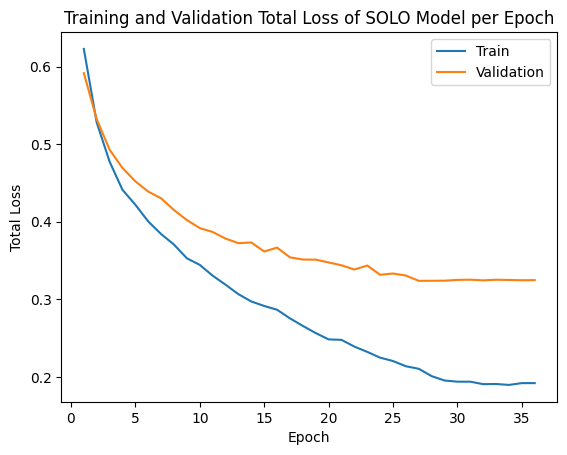

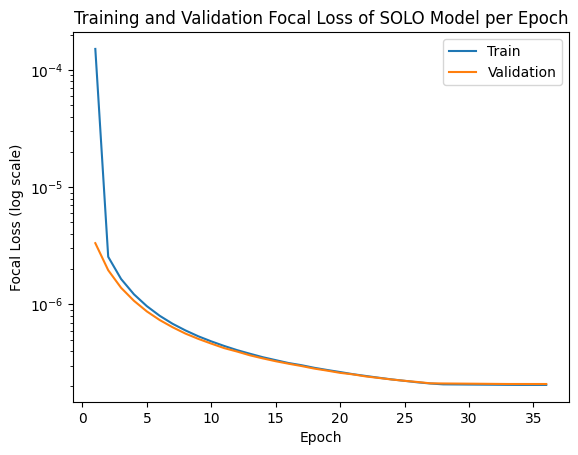

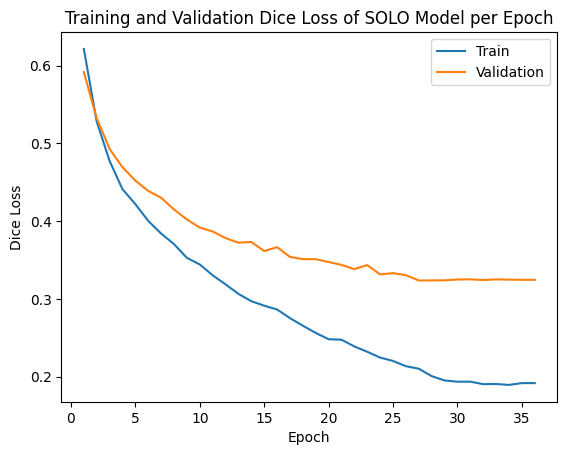

In [5]:
# Plot the results
train_total_loss_list = np.load('train_total_loss_list_epoch_36.npy').tolist()
train_mask_loss_list = np.load('train_mask_loss_list_epoch_36.npy').tolist()
train_cate_loss_list = np.load('train_cate_loss_list_epoch_36.npy').tolist()
val_total_loss_list = np.load('val_total_loss_list_epoch_36.npy').tolist()
val_mask_loss_list = np.load('val_mask_loss_list_epoch_36.npy').tolist()
val_cate_loss_list = np.load('val_cate_loss_list_epoch_36.npy').tolist()

epoch = np.arange(1, len(train_total_loss_list)+1)
os.makedirs("./testfig", exist_ok=True)

plt.plot(epoch, train_total_loss_list, label='Train')
plt.plot(epoch, val_total_loss_list, label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training and Validation Total Loss of SOLO Model per Epoch')
plt.legend()
plt.savefig("./testfig/total_loss.png")
plt.show()

plt.plot(epoch, train_cate_loss_list, label='Train')
plt.plot(epoch, val_cate_loss_list, label='Validation')
plt.yscale('log')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Focal Loss (log scale)')
plt.title('Training and Validation Focal Loss of SOLO Model per Epoch')
plt.legend()
plt.savefig("./testfig/focal_loss.png")
plt.show()

plt.plot(epoch, train_mask_loss_list, label='Train')
plt.plot(epoch, val_mask_loss_list, label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.title('Training and Validation Dice Loss of SOLO Model per Epoch')
plt.legend()
plt.savefig("./testfig/dice_loss.png")
plt.show()

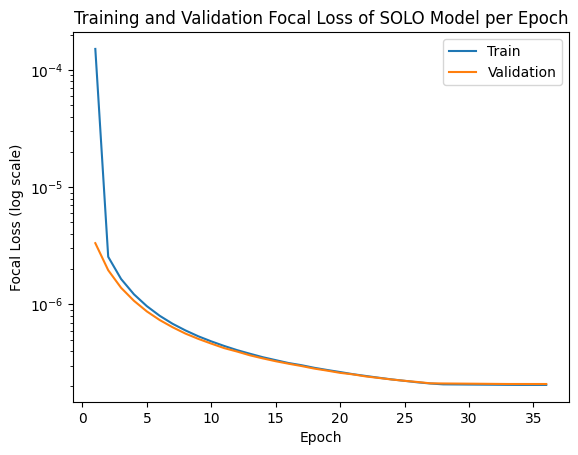

In [8]:
plt.plot(epoch, train_cate_loss_list, label='Train')
plt.plot(epoch, val_cate_loss_list, label='Validation')
plt.yscale('log')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Focal Loss (log scale)')
plt.title('Training and Validation Focal Loss of SOLO Model per Epoch')
plt.legend()
plt.savefig('focal_loss.png')
plt.show()

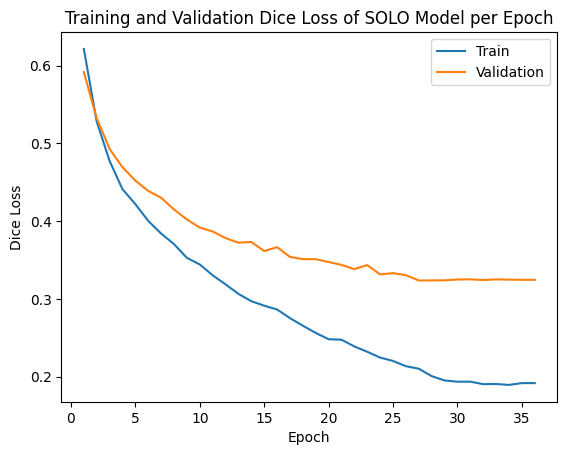

In [7]:
plt.plot(epoch, train_mask_loss_list, label='Train')
plt.plot(epoch, val_mask_loss_list, label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.title('Training and Validation Dice Loss of SOLO Model per Epoch')
plt.legend()
plt.savefig('dice_loss.png')
plt.show()

_INFERENCE CODE:_

_Due to the possibility of running out of RAM, we recommend disconnecting and deleting the runtime before executing the below cells for the inference code._

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/CIS6800HW3

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torch.nn.functional as F
import numpy as np
import gc
import matplotlib.pyplot as plt
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from backbone import *
from dataset import *
from solo_head import *

/content/gdrive/MyDrive/CIS6800HW3


In [3]:
imgs_path = './data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = './data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = "./data/hw3_mycocodata_labels_comp_zlib.npy"
bboxes_path = "./data/hw3_mycocodata_bboxes_comp_zlib.npy"
paths = [imgs_path, masks_path, labels_path, bboxes_path]
dataset = BuildDataset(paths)

In [4]:
batch_size = 1
train_proportion = 0.8

full_size = len(dataset)
val_size = 655 # Approx 1/5 of dataset
train_size = full_size - val_size

torch.random.manual_seed(1)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

val_build_loader = BuildDataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = val_build_loader.loader()

resnet50_fpn = Resnet50Backbone(device=device).to(device)
solo_head = SOLOHead(num_classes=4).to(device)
solo_head.load_state_dict(torch.load('solo_head_epoch_36_minibatch_0.pth'))

ori_size = (800, 1088)

num_images_to_output = 1

all_levels_one_batch = 0
for S in solo_head.seg_num_grids:
    all_levels_one_batch += S * S

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

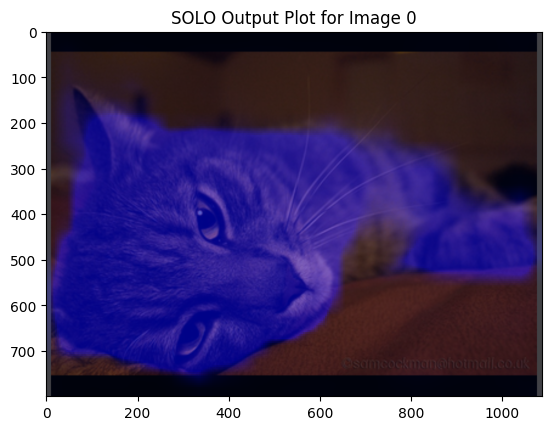

In [14]:
for val_batch_idx, val_data in enumerate(val_loader):
    img_val, mask_list_val, label_list_val, bbox_list_val = [val_data[i] for i in range(len(val_data))]

    backout_val = resnet50_fpn(img_val.to(device))
    fpn_feat_list_val = list(backout_val.values())

    cate_pred_list_val, ins_pred_list_val = solo_head.forward(fpn_feat_list_val, device, eval=True)

    NMS_sorted_scores_list, NMS_sorted_cate_label_list, NMS_sorted_ins_list = solo_head.PostProcess(ins_pred_list_val, cate_pred_list_val, ori_size, device)

    solo_head.PlotInfer(NMS_sorted_scores_list, NMS_sorted_cate_label_list, NMS_sorted_ins_list, img_val, val_batch_idx)

    if (val_batch_idx + 1) * batch_size >= num_images_to_output:
        break